In [4]:
from typing import *
import torch
from torch import nn
from torchtyping import TensorType, patch_typeguard
from transformer import Transformer
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
import numpy as np
from permutation import Permutation

%load_ext autoreload
%autoreload 2

patch_typeguard()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device used : {device}')

Device used : cuda:0


# Dataset generation definitions

In [6]:
@dataclass
class Dataset:
    train_x: TensorType["batch", "seq_len"]
    train_y: TensorType["batch", "seq_len"]
    test_x: TensorType["batch", "seq_len"]
    test_y: TensorType["batch", "seq_len"]

def split_dataset(data_x, data_y, prop: float = 0.8) -> Dataset:
    """
    Split the given dataset into training and test sets.
    """
    order = torch.randperm(data_x.shape[0])
    train_size = int(prop * data_x.shape[0])

    return Dataset(
        train_x = data_x[order[:train_size]],
        train_y = data_y[order[:train_size]],
        test_x = data_x[order[train_size:]],
        test_y = data_y[order[train_size:]],
    )

class BinaryOperator:
    def __init__(self, op):
        self.op     = np.vectorize(op)
        
    def apply(self, x, y):
        return self.op(x, y)
    
composition = BinaryOperator(lambda x, y: x * y)

def get_lehmer(n):
    return np.vectorize(lambda perm: perm.lehmer(n))

def create_dataset_v2(op: BinaryOperator, x, y, p):
    xv, yv = np.meshgrid(x, y)
    
    numeric_results = op.apply(xv, yv)
    
    lehmer_transform = get_lehmer(p)
    numeric_results = lehmer_transform(numeric_results)
    
    xv = lehmer_transform(xv)
    yv = lehmer_transform(yv)
        
    ds = np.dstack((xv, yv))
    ds_size = ds.size

    inputs  = torch.tensor(np.dstack((xv, yv)).reshape((ds_size//2, 2))).long().to(device)
    outputs = torch.tensor(numeric_results.reshape((ds_size//2))).long().to(device)
    return inputs, outputs 

# Training

In [7]:
@dataclass
class TrainingLog:
    train_losses: list[float] = field(default_factory=list)
    test_losses: list[float] = field(default_factory=list)
    train_acc: list[float] = field(default_factory=list)
    test_acc: list[float] = field(default_factory=list)
    epochs: list[float] = field(default_factory=list)

    def plot(self):
        # Two plots, one for loss, one for accuracy
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.set_xscale("log")
        ax1.plot(self.epochs, self.train_losses, label="training")
        ax1.plot(self.epochs, self.test_losses, label="test")
        ax1.title.set_text("Loss")
        ax1.legend()
        
        ax2.set_xscale("log")
        ax2.plot(self.epochs, self.train_acc, label="training")
        ax2.plot(self.epochs, self.test_acc, label="test")
        # line at acc = 1
        ax2.axhline(1, color="black", linestyle="--")
        ax2.title.set_text("Accuracy")
        ax2.legend()
        
def train(epochs, model, optimizer, data: Dataset, logs: TrainingLog):
    loss_fn = nn.CrossEntropyLoss()

    if logs.epochs:
        start_epoch = logs.epochs[-1] + 1
    else:
        start_epoch = 0

    for epoch in range(start_epoch, start_epoch + epochs):
        pred = model(data.train_x)
        loss = loss_fn(pred, data.train_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if epoch % 10 == 0:
            logs.epochs.append(epoch)
            logs.train_losses.append(loss.item())
            logs.train_acc.append((pred.argmax(dim=1) == data.train_y).float().mean().item())
            test_pred = model(data.test_x)
            logs.test_losses.append(loss_fn(test_pred, data.test_y).item())
            logs.test_acc.append((test_pred.argmax(dim=1) == data.test_y).float().mean().item())

# Experiments

In [8]:
OPTIMIZATION_BUDGET = 10000

In [19]:
def choose_optimizer(model: Transformer, idx: int):
    match idx:
        case 0: return torch.optim.Adam(model.parameters())
        case 1: return torch.optim.AdamW(model.parameters(), weight_decay=1)
        case 2: return torch.optim.Adam(model.parameters(), lr=3e-4)
        case 3: return torch.optim.Adam(model.parameters(), lr=3e-3)
    

def optimizer_experiment(op: BinaryOperator):
    S5 = list(Permutation.group(5))
    logs_array = []
    for i in range(4):
        
        dmodel = 128
        avg_accs = []
        split = 0.7

        data_x, data_y = create_dataset_v2(op, S5, S5, p=5)
        data = split_dataset(data_x, data_y, split)

        model = Transformer(
            voc_size=120,
            embedding_size=dmodel,
            depth=2,
            heads=4,
            mlp_dims=[4 * dmodel],
        ).to(device)

        epochs = OPTIMIZATION_BUDGET

        optimizer=choose_optimizer(model, i)

        logs = TrainingLog()
        train(epochs, model, optimizer, data, logs)

        logs_array.append(logs)
            
    return logs_array

logs_array = optimizer_experiment(composition)

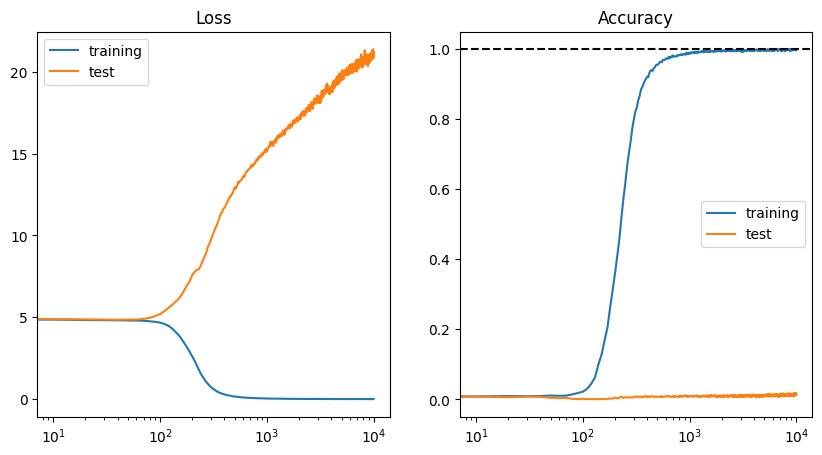

In [20]:
logs_array[0].plot()

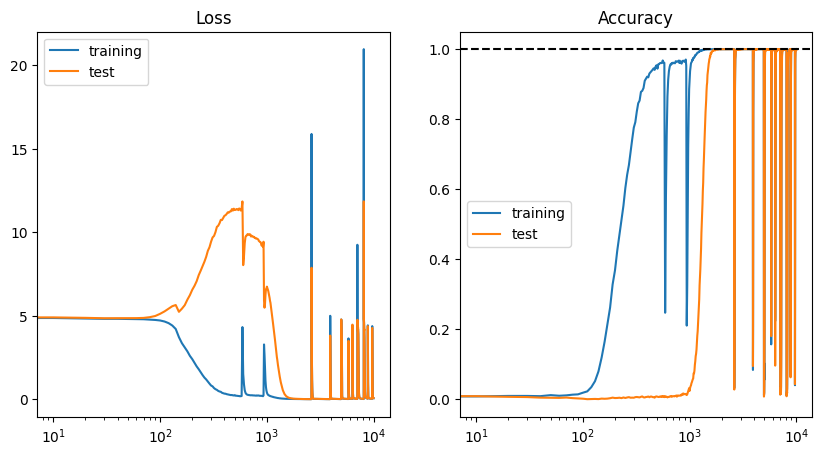

In [21]:
logs_array[1].plot()

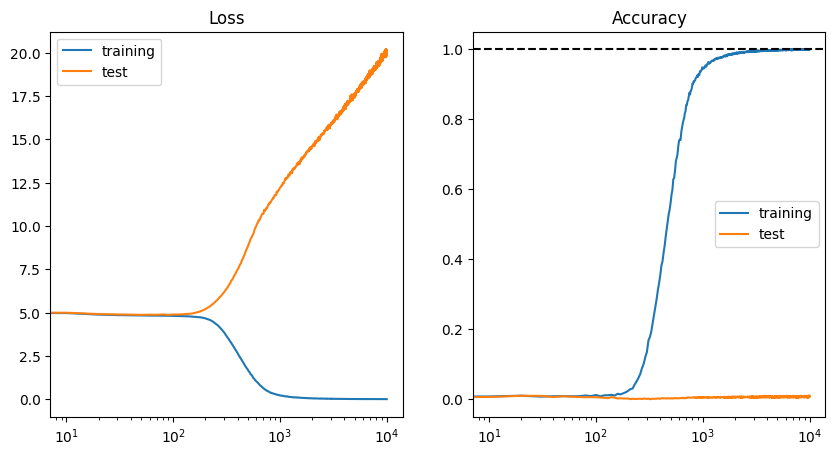

In [22]:
logs_array[2].plot()

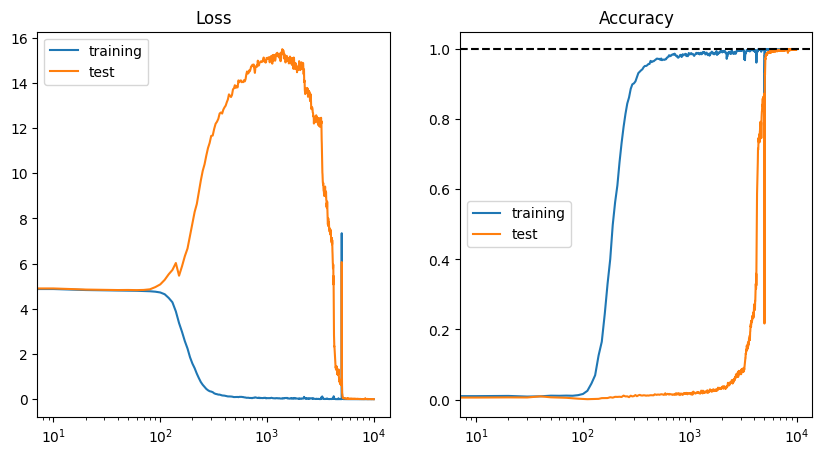

In [23]:
logs_array[3].plot()